# 데이터 준비

In [1]:
import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize

from torchtext.legacy.data import Field
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import BucketIterator
from torchtext.legacy.data import Iterator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
DATA_PATH = "/content/drive/Othercomputers/내 컴퓨터/Sat_english/data/processed"

필드 정의

In [29]:
# 문장 필드
TEXT = Field(
    sequential=True,    # 문장 입력
    use_vocab=True,     
    tokenize=word_tokenize,     # nltk의 word_tokenize로 트큰화
    lower=True,         # 모두 소문자 처리
    batch_first=True,
)

# 정답 필드
LABEL = Field(
    sequential=False,
    use_vocab=False,
    batch_first=True,
)

데이터 불러오기

In [30]:
# CoLA 데이터 = 사전 학습 데이터
cola_train_data, cola_valid_data, cola_test_data = TabularDataset.splits(
    path=DATA_PATH,
    train="cola_train.tsv",
    validation="cola_valid.tsv",
    test="cola_test.tsv",
    format="tsv",
    fields=[("text", TEXT), ("label", LABEL)],
    skip_header=1,          # column명이 있는 1열 생략
)

TEXT.build_vocab(cola_train_data, min_freq=2)   # CoLA 데이터로 사전학습할 단어장 생성(2번 이상 나온 단어만)

# 수능 데이터 = 추가 학습 데이터
sat_train_data, sat_valid_data, sat_test_data = TabularDataset.splits(
    path=DATA_PATH,
    train="sat_train.tsv",
    validation="sat_valid.tsv",
    test="sat_test.tsv",
    format="tsv",
    fields=[("text", TEXT), ("label", LABEL)],
    skip_header=1,
)

DataLoader 정의

In [31]:
# CoLA 데이터
cola_train_iterator, cola_valid_iterator, cola_test_iterator = BucketIterator.splits(
    (cola_train_data, cola_valid_data, cola_test_data),
    batch_size=32,
    device=None,
    sort=False,
)

# 수능 데이터
sat_train_iterator, sat_valid_iterator, sat_test_iterator = BucketIterator.splits(
    (sat_train_data, sat_valid_data, sat_test_data),
    batch_size=8,
    device=None,
    sort=False,
)

# 네트워크 구성

In [32]:
import torch
import torch.nn as nn

In [33]:
class LSTM_Model(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, pad_idx):
        super().__init__()

        # Embedding Layer
        self.embed_layer = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim, 
            padding_idx=pad_idx
        )

        # LSTM Layer
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first = True,
            bidirectional=True,     # 양방향 LSTM
            dropout=0.5
        )

        # Fully-connetcted Layer
        self.fc_layer1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),    # 양방향 LSTM의 출력은 입력의 2배
            nn.Dropout(0.5),
            nn.LeakyReLU()      # f(x)=max(0.01x, x)로 dying ReLU 방지
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()        # 확률 출력을 위함
        )

    def forward(self, x):
        embed_x = self.embed_layer(x)

        output, (_, _) = self.lstm_layer(embed_x)       # hidden, cell state의 출력값 사용 안함
        
        output = output[:, -1, :]       # (batch_size, seq_length, 2*hidden_size) -> (batch_size, 2*hidden_size)

        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        return output

# 모델 학습 및 검증

파라미터 정의

In [34]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")    # GPU 존재시 GPU 실행(CUDA)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]       # 동일한 크기를 맞추기 위한 패딩문자를 숫자 식별자에 매칭 -> 숫자 식별자=index

lstm = LSTM_Model(
        num_embeddings=len(TEXT.vocab),
        embedding_dim=100,
        hidden_size=200,
        num_layers=4,
        pad_idx=PAD_IDX
    ).to(DEVICE)

n_epochs = 30
learning_rate = 0.001

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

훈련 데이터로 학습하여 모델화

In [35]:
def train(model, iterator, optimizer):
    train_loss = 0

    model.train()       # 모델을 train모드로 설정(Dropout 적용)
    for _, batch in enumerate(iterator):
        optimizer.zero_grad()   # optimizer 초기화(Gradient)

        text = batch.text      # 해당 Batch의 text 속성 불러오기
        label = batch.label.type(torch.FloatTensor)     # 해당 Batch의 label 속성 불러오기(32-bit float)

        text = text.to(DEVICE)
        label = label.to(DEVICE)

        output = model(text).flatten()        # output은 [batch_size, 1], label은 [batch_size]

        loss = criterion(output, label)
        loss.backward()     # 역전파로 Gradient를 계산 후 파라미터에 할당
        optimizer.step()    # 파라미터 업데이트


        train_loss += loss.item()   # Loss 값 누적

    return train_loss / len(iterator)       # Loss 값을 Batch 값으로 나누어 미니 배치마다의 Loss 값의 평균을 구함

모델 검증

In [36]:
def evaluate(model, iterator):
    valid_loss = 0

    model.eval()        # 모델을 eval모드로 설정(Dropout 미적용)
    with torch.no_grad():       # Gradient 계산 비활성화 (모델 평가에는 파라미터 업데이트 X)
        for _, batch in enumerate(iterator):
            text = batch.text
            label = batch.label.type(torch.FloatTensor)

            text = text.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(text).flatten()
            
            loss = criterion(output, label)

            valid_loss += loss.item()

    return valid_loss / len(iterator)

CoLA 데이터 사전학습

In [37]:
import time

In [38]:
def epoch_time(start_time: int, end_time: int):     # epoch 시간
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
loss_tr = []
loss_val = []

In [40]:
for epoch in range(n_epochs):

    start_time = time.time()

    train_loss = train(lstm, cola_train_iterator, optimizer)
    valid_loss = evaluate(lstm, cola_valid_iterator)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")

    # overfitting 확인하기 위한 플롯 그리기
    loss_tr.append(train_loss)
    loss_val.append(valid_loss)


Epoch: 01 | Time: 0m 12s
	Train Loss: 0.61354
	 Val. Loss: 0.61748
Epoch: 02 | Time: 0m 12s
	Train Loss: 0.60990
	 Val. Loss: 0.62936
Epoch: 03 | Time: 0m 12s
	Train Loss: 0.60569
	 Val. Loss: 0.61707
Epoch: 04 | Time: 0m 12s
	Train Loss: 0.60506
	 Val. Loss: 0.61961
Epoch: 05 | Time: 0m 12s
	Train Loss: 0.60406
	 Val. Loss: 0.61710
Epoch: 06 | Time: 0m 12s
	Train Loss: 0.60466
	 Val. Loss: 0.61430
Epoch: 07 | Time: 0m 12s
	Train Loss: 0.59660
	 Val. Loss: 0.61830
Epoch: 08 | Time: 0m 12s
	Train Loss: 0.59074
	 Val. Loss: 0.62332
Epoch: 09 | Time: 0m 12s
	Train Loss: 0.58121
	 Val. Loss: 0.63928
Epoch: 10 | Time: 0m 12s
	Train Loss: 0.58054
	 Val. Loss: 0.62270
Epoch: 11 | Time: 0m 12s
	Train Loss: 0.58528
	 Val. Loss: 0.61786
Epoch: 12 | Time: 0m 12s
	Train Loss: 0.59676
	 Val. Loss: 0.61212
Epoch: 13 | Time: 0m 12s
	Train Loss: 0.59602
	 Val. Loss: 0.62627
Epoch: 14 | Time: 0m 12s
	Train Loss: 0.58606
	 Val. Loss: 0.63724
Epoch: 15 | Time: 0m 12s
	Train Loss: 0.58402
	 Val. Loss: 0.6

In [41]:
import numpy as np
import matplotlib.pyplot as plt

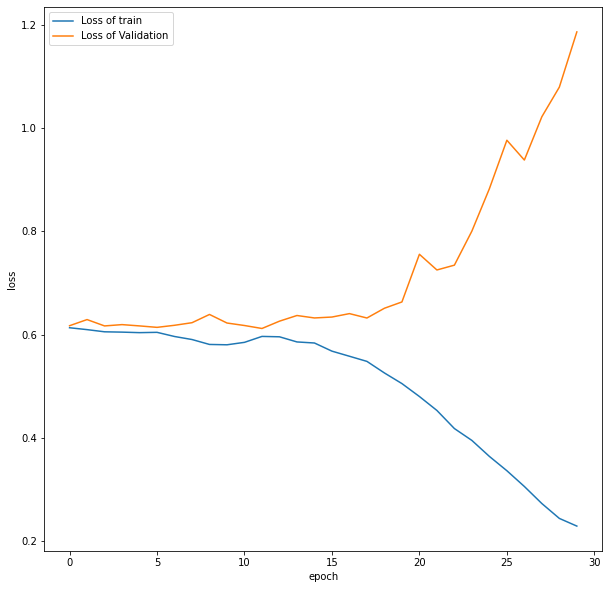

In [42]:
np1 = np.array(loss_tr)
np2 = np.array(loss_val)

plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(np1, label='Loss of train')
plt.plot(np2, label='Loss of Validation')
plt.legend()  # 라벨표시를 위한 범례

plt.show()